Download the dataset from here: https://www.kaggle.com/datasets/camnugent/california-housing-prices/data

In [9]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

In [2]:
spark = SparkSession.builder \
    .appName("RandomForestCaliforniaHousing") \
    .getOrCreate()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/12 17:59:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
csv_file_path = "datasets/CHP/housing.csv"  # Adjust the file path accordingly
df = spark.read.csv(csv_file_path, header=True, inferSchema=True)


In [5]:
df.show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|
|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|     219.0|       5.6431|          341300.0|       NEAR BAY|
|  -122.25|   37.85|              

In [6]:
# Preprocessing
# 1. Handle Missing Values (if any)
# Here, we'll drop rows with missing values for simplicity
df = df.dropna()

In [7]:
# 2. Feature Scaling
# Assemble features into a single vector column
feature_cols = df.columns[:-1]  # All columns except the target variable
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_assembled = assembler.transform(df)

In [8]:
# Scale features to have zero mean and unit standard deviation
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(df_assembled)
df_scaled = scaler_model.transform(df_assembled)

In [10]:
# 4. Handling Categorical Variables

indexer = StringIndexer(inputCol="ocean_proximity", outputCol="ocean_proximity_indexed")

# One-hot encode the indexed column
encoder = OneHotEncoder(inputCol="ocean_proximity_indexed", outputCol="ocean_proximity_encoded")

# Define the stages of the pipeline
pipeline = Pipeline(stages=[indexer, encoder])

# Fit the pipeline to the data
pipeline_model = pipeline.fit(df_scaled)

# Transform the data using the pipeline
df_transformed = pipeline_model.transform(df_scaled)

In [12]:
df_transformed.columns

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value',
 'ocean_proximity',
 'features',
 'scaled_features',
 'ocean_proximity_indexed',
 'ocean_proximity_encoded']

In [15]:
df_transformed.schema

StructType([StructField('longitude', DoubleType(), True), StructField('latitude', DoubleType(), True), StructField('housing_median_age', DoubleType(), True), StructField('total_rooms', DoubleType(), True), StructField('total_bedrooms', DoubleType(), True), StructField('population', DoubleType(), True), StructField('households', DoubleType(), True), StructField('median_income', DoubleType(), True), StructField('median_house_value', DoubleType(), True), StructField('ocean_proximity', StringType(), True), StructField('features', VectorUDT(), True), StructField('scaled_features', VectorUDT(), True), StructField('ocean_proximity_indexed', DoubleType(), False), StructField('ocean_proximity_encoded', VectorUDT(), True)])

In [17]:
# 5. Train-Test Split
train_data, test_data = df_scaled.randomSplit([0.8, 0.2], seed=42)

# Define the Random Forest model
rf = RandomForestRegressor(featuresCol="scaled_features", labelCol="median_house_value")

# Train the Random Forest model
rf_model = rf.fit(train_data)

# Make predictions on the test data
predictions = rf_model.transform(test_data)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="median_house_value", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data:", rmse)

Root Mean Squared Error (RMSE) on test data: 24661.031538643125


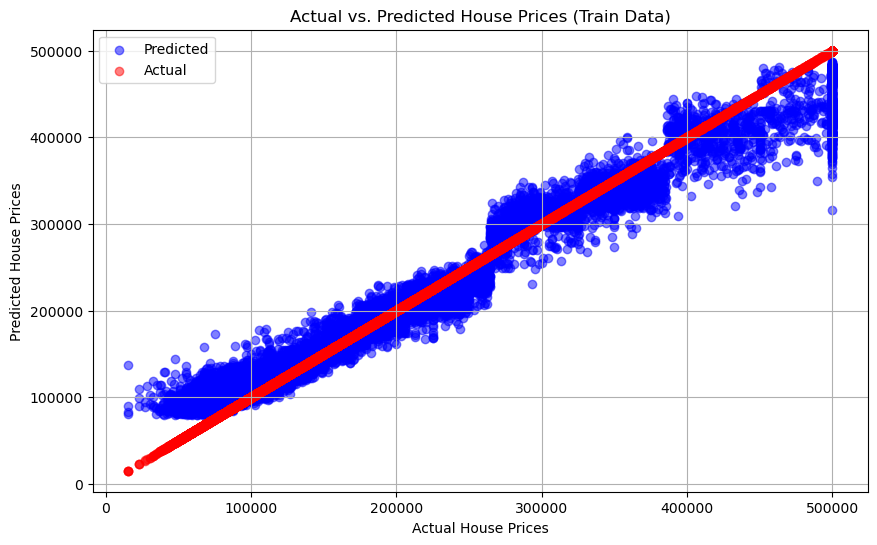

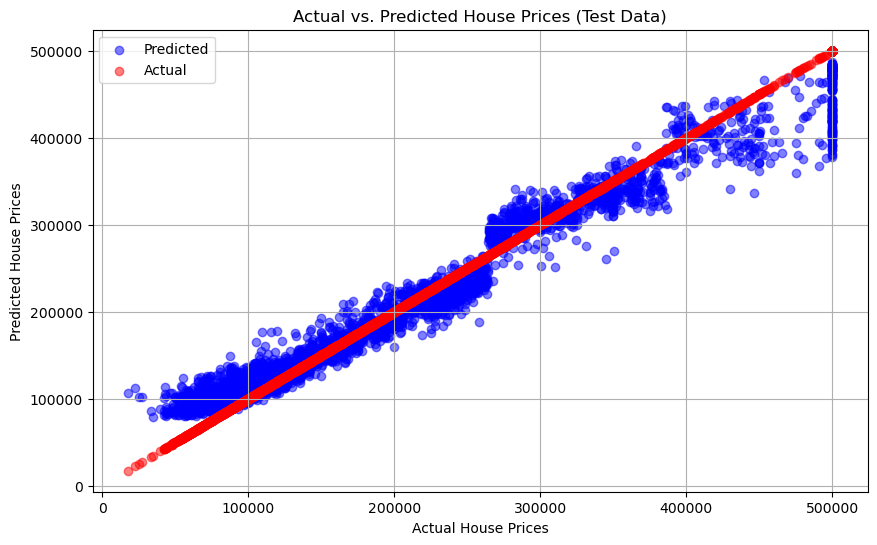

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Convert predictions to Pandas DataFrame for easier plotting
train_predictions_pd = rf_model.transform(train_data).select("median_house_value", "prediction").toPandas()
test_predictions_pd = rf_model.transform(test_data).select("median_house_value", "prediction").toPandas()

# Plotting actual vs. predicted house prices for train data
plt.figure(figsize=(10, 6))
plt.scatter(train_predictions_pd["median_house_value"], train_predictions_pd["prediction"], c='blue', alpha=0.5, label='Predicted')
plt.scatter(train_predictions_pd["median_house_value"], train_predictions_pd["median_house_value"], c='red', alpha=0.5, label='Actual')
plt.title("Actual vs. Predicted House Prices (Train Data)")
plt.xlabel("Actual House Prices")
plt.ylabel("Predicted House Prices")
plt.legend()
plt.grid(True)
plt.show()

# Plotting actual vs. predicted house prices for test data
plt.figure(figsize=(10, 6))
plt.scatter(test_predictions_pd["median_house_value"], test_predictions_pd["prediction"], c='blue', alpha=0.5, label='Predicted')
plt.scatter(test_predictions_pd["median_house_value"], test_predictions_pd["median_house_value"], c='red', alpha=0.5, label='Actual')
plt.title("Actual vs. Predicted House Prices (Test Data)")
plt.xlabel("Actual House Prices")
plt.ylabel("Predicted House Prices")
plt.legend()
plt.grid(True)
plt.show()